## Imports

In [2]:
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import os

In [3]:
%load_ext autoreload
%autoreload 1
%aimport utilities

from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializations

In [26]:
total_spins = 6
input_sys_size = 1

# hilbert spaces
spin_space_B = HilbertSpace(total_spins-input_sys_size, 'spin')
spin_space_A = HilbertSpace(input_sys_size, 'spin')

# composite hilbert space
hilbert_spaces_dict = {'spin_A': spin_space_A,
                       'spin_B': spin_space_B}
composite_space = CompositeHilbertSpace(hilbert_spaces_dict)

# time parameters
T_evolution = 10

# initial state
rho_0_spins=np.zeros((2**total_spins,2**total_spins),dtype=np.complex128)
rho_0_spins[0][0]=1.0+1j*0.0
rho_0 = DensityMatrix(rho_0_spins)

## Functions & utilities

### Generate the reservoir's Hamiltonian

In [27]:
def get_couplings(n_spins, J):
    # start with all random
    J_bare = np.random.uniform(low = -0.5+J, high = 0.5*J, size=(n_spins,n_spins))
    # exclude spin self-interaction
    for i in range(n_spins):
        J_bare[i,i] = 0 
    # make symmetric
    J_bare = np.triu(J_bare, k = 1)
    J_bare = 0.5*(J_bare  + J_bare.T)
    return J_bare

In [28]:
def get_hamiltonian(
        composite_space,
        h = 10,
        J = 1
    ):
    # reservoir hamiltonian
    H_reservoir = np.zeros((composite_space.dimension, composite_space.dimension))
    # compute number of spins
    total_spins = np.sum([hs.n for hs in composite_space.hilbert_spaces_dict.values() if hs.system == "spin"])
    # get couplings
    J_bare = get_couplings(total_spins, J)
    ## XX terms
    for i in range(1, total_spins+1):
        for j in range(i+1, total_spins+1):
            H_reservoir += J*J_bare[i-1, j-1]*composite_space.X[i]@composite_space.X[j]
    ## Z terms
    for i in range(1, total_spins+1):
        H_reservoir += 0.5*h*composite_space.Z[i]
    return H_reservoir

### Measurement process

In [4]:
# Define the function to generate the M matrix
def M_matrix(N,g): 
    Mi = np.array([[1.0,np.exp(-g**2/2)],[np.exp(-g**2/2),1]],dtype=np.complex128)
    M = Mi*1
    for j in range(N-1):
        M = np.kron(M,Mi)
    return M

In [29]:
# define basis change matrices
## X
# hadamard matrix on 1 qubit
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
# make it complex
H = H.astype(complex)
# tensor product of H with itself for all qubits
H_total = H
for i in range(total_spins-1):
    H_total = np.kron(H_total, H)
X_basis_change = H_total
X_basis_change_dag = X_basis_change.conj().T
## Y
S = np.array([[1, 0], [0, -np.exp(1j*np.pi/2)]], dtype=complex)
# tensor product of S with itself for all qubits
S_total = S
for i in range(total_spins-1):
    S_total = np.kron(S_total, S)
Y_basis_change = H_total@S_total
Y_basis_change_dag = Y_basis_change.conj().T

### Compute the reservoir's performance

In [125]:
def compute_capacity(features_df, time_series, eta, f_p = True):
    tot_width = features_df.shape[1]

    N_raw_data = len(features_df)
    N_skip = 20
    data_size = N_raw_data - N_skip
    N_total = data_size

    X_data = pt.zeros(data_size, tot_width, dtype=float)
    Y_ini_data = pt.zeros(data_size, 1, dtype=float)
    for k in range(0, data_size):
        X_data[k] = pt.tensor(features_df.loc[k, :].values, dtype=float)
        Y_ini_data[k] = time_series[k]

    eta = abs(eta)
    # -eta - gives future prediction
    # +eta - gives memory
    if f_p:
        eta = -eta

    Y_data = pt.roll(Y_ini_data, -eta)

    fraction_train = 0.7

    N_train = int(fraction_train*N_total)
    N_test = N_total - N_train

    X_train = X_data[0: N_train, :].float()
    y_train = Y_data[0: N_train].float()

    X_test = X_data[-N_test:, :].float()
    y_test = Y_data[-N_test:].float()

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train = y_train.detach().numpy()
    y_test = y_test.detach().numpy()

    absolutcapacity_train = np.cov(y_train.T, y_train_pred.T, ddof=1)
    absolutcapacity_train = absolutcapacity_train[0, 1]**2/(
        (np.var(y_train, ddof=1))*(np.var(y_train_pred, ddof=1)))

    absolutcapacity_test = np.cov(y_test.T, y_test_pred.T, ddof=1)
    absolutcapacity_test = absolutcapacity_test[0, 1]**2/(
        (np.var(y_test, ddof=1))*(np.var(y_test_pred, ddof=1)))
    
    return absolutcapacity_train, absolutcapacity_test


In [122]:
def compute_sum_capacity(features_df, time_series, eta_max, f_p = True):
    tot_width = features_df.shape[1]

    N_raw_data = len(features_df)
    N_skip = 20
    data_size = N_raw_data - N_skip
    N_total = data_size

    X_data = pt.zeros(data_size, tot_width, dtype=float)
    Y_ini_data = pt.zeros(data_size, 1, dtype=float)
    for k in range(0, data_size):
        X_data[k] = pt.tensor(features_df.loc[k, :].values, dtype=float)
        Y_ini_data[k] = time_series[k]
        
    eta_vec = np.arange(1, eta_max+1)
    capacities_train = []
    capacities_test = []
    for eta in eta_vec:
        # +eta - gives memory
        if f_p:
            eta = -eta

        Y_data = pt.roll(Y_ini_data, -eta)

        fraction_train = 0.7

        N_train = int(fraction_train*N_total)
        N_test = N_total - N_train

        X_train = X_data[0: N_train, :].float()
        y_train = Y_data[0: N_train].float()

        X_test = X_data[-N_test:, :].float()
        y_test = Y_data[-N_test:].float()

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        y_train = y_train.detach().numpy()
        y_test = y_test.detach().numpy()

        absolutcapacity_train = np.cov(y_train.T, y_train_pred.T, ddof=1)
        absolutcapacity_train = absolutcapacity_train[0, 1]**2/(
            (np.var(y_train, ddof=1))*(np.var(y_train_pred, ddof=1)))

        absolutcapacity_test = np.cov(y_test.T, y_test_pred.T, ddof=1)
        absolutcapacity_test = absolutcapacity_test[0, 1]**2/(
            (np.var(y_test, ddof=1))*(np.var(y_test_pred, ddof=1)))
        
        capacities_train.append(absolutcapacity_train)
        capacities_test.append(absolutcapacity_test)

    # sum capacity test
    sum_capacity_test = np.sum(capacities_test)
    return sum_capacity_test

### Output database utils

In [35]:
# define keys of the data_frame 
column_lenght_dict = {
    'X': total_spins,
    'Y': total_spins,
    'Z': total_spins,
    'XX': total_spins*(total_spins+1)//2,
    'YY': total_spins*(total_spins+1)//2,
    'ZZ': total_spins*(total_spins+1)//2
}
df_columns = []
for col in column_lenght_dict.keys():
    for i in range(column_lenght_dict[col]):
        df_columns.append(col + str(i))

In [36]:
def dict_to_arr(data_dict):
    # Determine the number of lists in each key
    num_lists_per_key = len(data_dict[next(iter(data_dict))])

    # Initialize an empty list for the concatenated lists
    concatenated_lists = []

    # Iterate through the range of the number of lists per key
    for i in range(num_lists_per_key):
        # Initialize an empty list for the current row
        current_row = []
        # Iterate through each key in the dictionary
        for key in data_dict:
            # Extend the current row list with the elements of the current list from the current key
            current_row.extend(data_dict[key][i])
        # Append the current row list to the concatenated lists
        concatenated_lists.append(current_row)

    # Convert the list to a numpy array
    structured_array = np.array(concatenated_lists)
    return structured_array

# Forward prediction task

In [51]:
# load data
time_series_raw = np.load("./sk_Santa_Fe_2000.npy")
K = len(time_series_raw)
# normalize data
min_ts = min(time_series_raw)
max_ts = max(time_series_raw)
time_series = (time_series_raw + np.abs(min_ts))/(max_ts-min_ts)
# flatten time series
time_series = time_series.flatten()

## Memory retrieval task

In [32]:
# load data
time_series = np.load("./time_series_smt.npy")

## Run QRC for a given $g$ and $h$

In [34]:
# select QRC parameters
# (a measurement strength of 0 corresponds to a simulation of the
#  restarting protocols for this system)
g = 0.5 
h = 1

In [17]:
# initialize Hamiltonian
H_reservoir = get_hamiltonian(composite_space, h)

# time evolution unitary
U_reservoir = scipy.linalg.expm(-1j*H_reservoir*T_evolution)
U_reservoir_dag = U_reservoir.conj().T

# back-action matrix
M = M_matrix(total_spins, g)

# initialize a dictionary to store the results
data = {
    'X': [],
    'Y': [],
    'Z': [],
    'XX': [],
    'YY': [],
    'ZZ': [],
}

# process time series
for obs in ['X', 'Y', 'Z']:
    rho = rho_0.dm
    for k in range(K):
        if isinstance(rho, DensityMatrix):
            rho = rho.dm

        # input encoding
        s_k = time_series[k]
        rho_B = composite_space.get_reduced_density_matrix(rho, ['spin_B'])
        rho_A = np.array([
            [1.-s_k, np.sqrt((1-s_k)*s_k)],
            [np.sqrt((1-s_k)*s_k), s_k]])
        rho = np.kron(rho_A, rho_B)

        # time evolution
        rho = U_reservoir@rho@U_reservoir_dag

        # measurement
        if obs == 'Z':
            ## apply M
            rho = np.multiply(M, rho)
            rho = DensityMatrix(rho)

            ## compute exp values for z_i
            ev_Z = []
            for i in range(1, total_spins+1):
                ev_Z.append(rho.get_expectation_value(composite_space.Z[i]))
            data['Z'].append(ev_Z)

            ## compute exp values for z_iz_j
            ev_ZZ = []
            for i in range(1, total_spins+1):
                for j in range(i, total_spins+1):
                    ev_ZZ.append(rho.get_expectation_value(composite_space.Z[i]@composite_space.Z[j]))
            data['ZZ'].append(ev_ZZ)

        elif obs == 'Y':
            ## rotate to Y basis
            rho = Y_basis_change@rho@Y_basis_change_dag
            ## apply M
            rho = np.multiply(M, rho)
            ## rotate back to Z basis
            rho = Y_basis_change_dag@rho@Y_basis_change
            rho = DensityMatrix(rho)

            ## compute exp values for y_i
            ev_Y = []
            for i in range(1, total_spins+1):
                ev_Y.append(rho.get_expectation_value(composite_space.Y[i]))
            data['Y'].append(ev_Y)

            ## compute exp values for y_iy_j
            ev_YY = []
            for i in range(1, total_spins+1):
                for j in range(i, total_spins+1):
                    ev_YY.append(rho.get_expectation_value(composite_space.Y[i]@composite_space.Y[j]))
            data['YY'].append(ev_YY)

        elif obs == 'X':
            ## rotate to X basis
            rho = X_basis_change@rho@X_basis_change_dag
            ## apply M
            rho = np.multiply(M, rho)
            ## rotate back to Z basis
            rho = X_basis_change_dag@rho@X_basis_change
            rho = DensityMatrix(rho)

            ## compute exp values for x_i
            ev_X = []
            for i in range(1, total_spins+1):
                ev_X.append(rho.get_expectation_value(composite_space.X[i]))
            data['X'].append(ev_X)

            ## compute exp values for x_ix_j
            ev_XX = []
            for i in range(1, total_spins+1):
                for j in range(i, total_spins+1):
                    ev_XX.append(rho.get_expectation_value(composite_space.X[i]@composite_space.X[j]))
            data['XX'].append(ev_XX)
data_arr = dict_to_arr(data)
features_df = pd.DataFrame(data_arr)
features_df.columns = df_columns

In [61]:
# compute capacity for a given eta
eta = 10
capacity_train, capacity_test = compute_capacity(features_df, time_series, eta, f_p=True)
print(f"Capacity for eta = {eta} is {np.round(capacity_test, 4)}")

Capacity for eta = 10 is 0.9506


In [62]:
# sum capacity up to a given eta_max
eta_max = 20
sum_capacity_test = compute_sum_capacity(features_df, time_series, eta_max, f_p=True)
print(f"Sum capacity for eta_max = {eta_max} is {np.round(sum_capacity_test, 4)}")

Sum capacity for eta_max = 20 is 17.8485


## Partially reproduce Fig 3 and 4 for the forward prediction task
Here we provide a minimal example of how to partially reproduce Fig 3 and 4 for the forward prediction task. We upload the output datasets of the QRC simulations that can be obtained by running the code in the previous cell for the different values of $g$ and $h$.

### Loading data utils

In [72]:
data_path = './data/'

In [90]:
def read_datafile(datapath, it, g, h):
    filename = 'features_df_{it}_g_{g:.2f}_h0_{h:.2f}.h5'.format(it=it, g=g, h=np.log10(h))
    features_df = pd.read_hdf(datapath + filename)
    return features_df

### Reservoir parameters for the different conditions

In [137]:
import json

# Load the configuration file
with open('./figure_params.json') as json_file:
    fig_params = json.load(json_file)

### Sum capacities vs $h$ plot

In [104]:
h_vec = np.logspace(-2, 2, 40)
g_rsp = fig_params['RSP_OPT']['g']
g_olp_opt = fig_params['OLP_OPT']['g']
g_olp_nopt = fig_params['OLP_NOOPT']['g']

# load data
dfs_rsp = []
dfs_olp_opt = []
dfs_olp_nopt = []
for h in h_vec:
    dfs_rsp.append(read_datafile(data_path, 20, g_rsp, h))
    dfs_olp_opt.append(read_datafile(data_path, 20, g_olp_opt, h))
    dfs_olp_nopt.append(read_datafile(data_path, 20, g_olp_nopt, h))

In [123]:
# compute sum capacity for all h
eta_max = 20
sum_capacities_rsp = []
sum_capacities_olp_opt = []
sum_capacities_olp_nopt = []
for i in range(len(h_vec)):
    sum_capacities_rsp.append(compute_sum_capacity(dfs_rsp[i], time_series, eta_max, f_p=True))
    sum_capacities_olp_opt.append(compute_sum_capacity(dfs_olp_opt[i], time_series, eta_max, f_p=True))
    sum_capacities_olp_nopt.append(compute_sum_capacity(dfs_olp_nopt[i], time_series, eta_max, f_p=True))

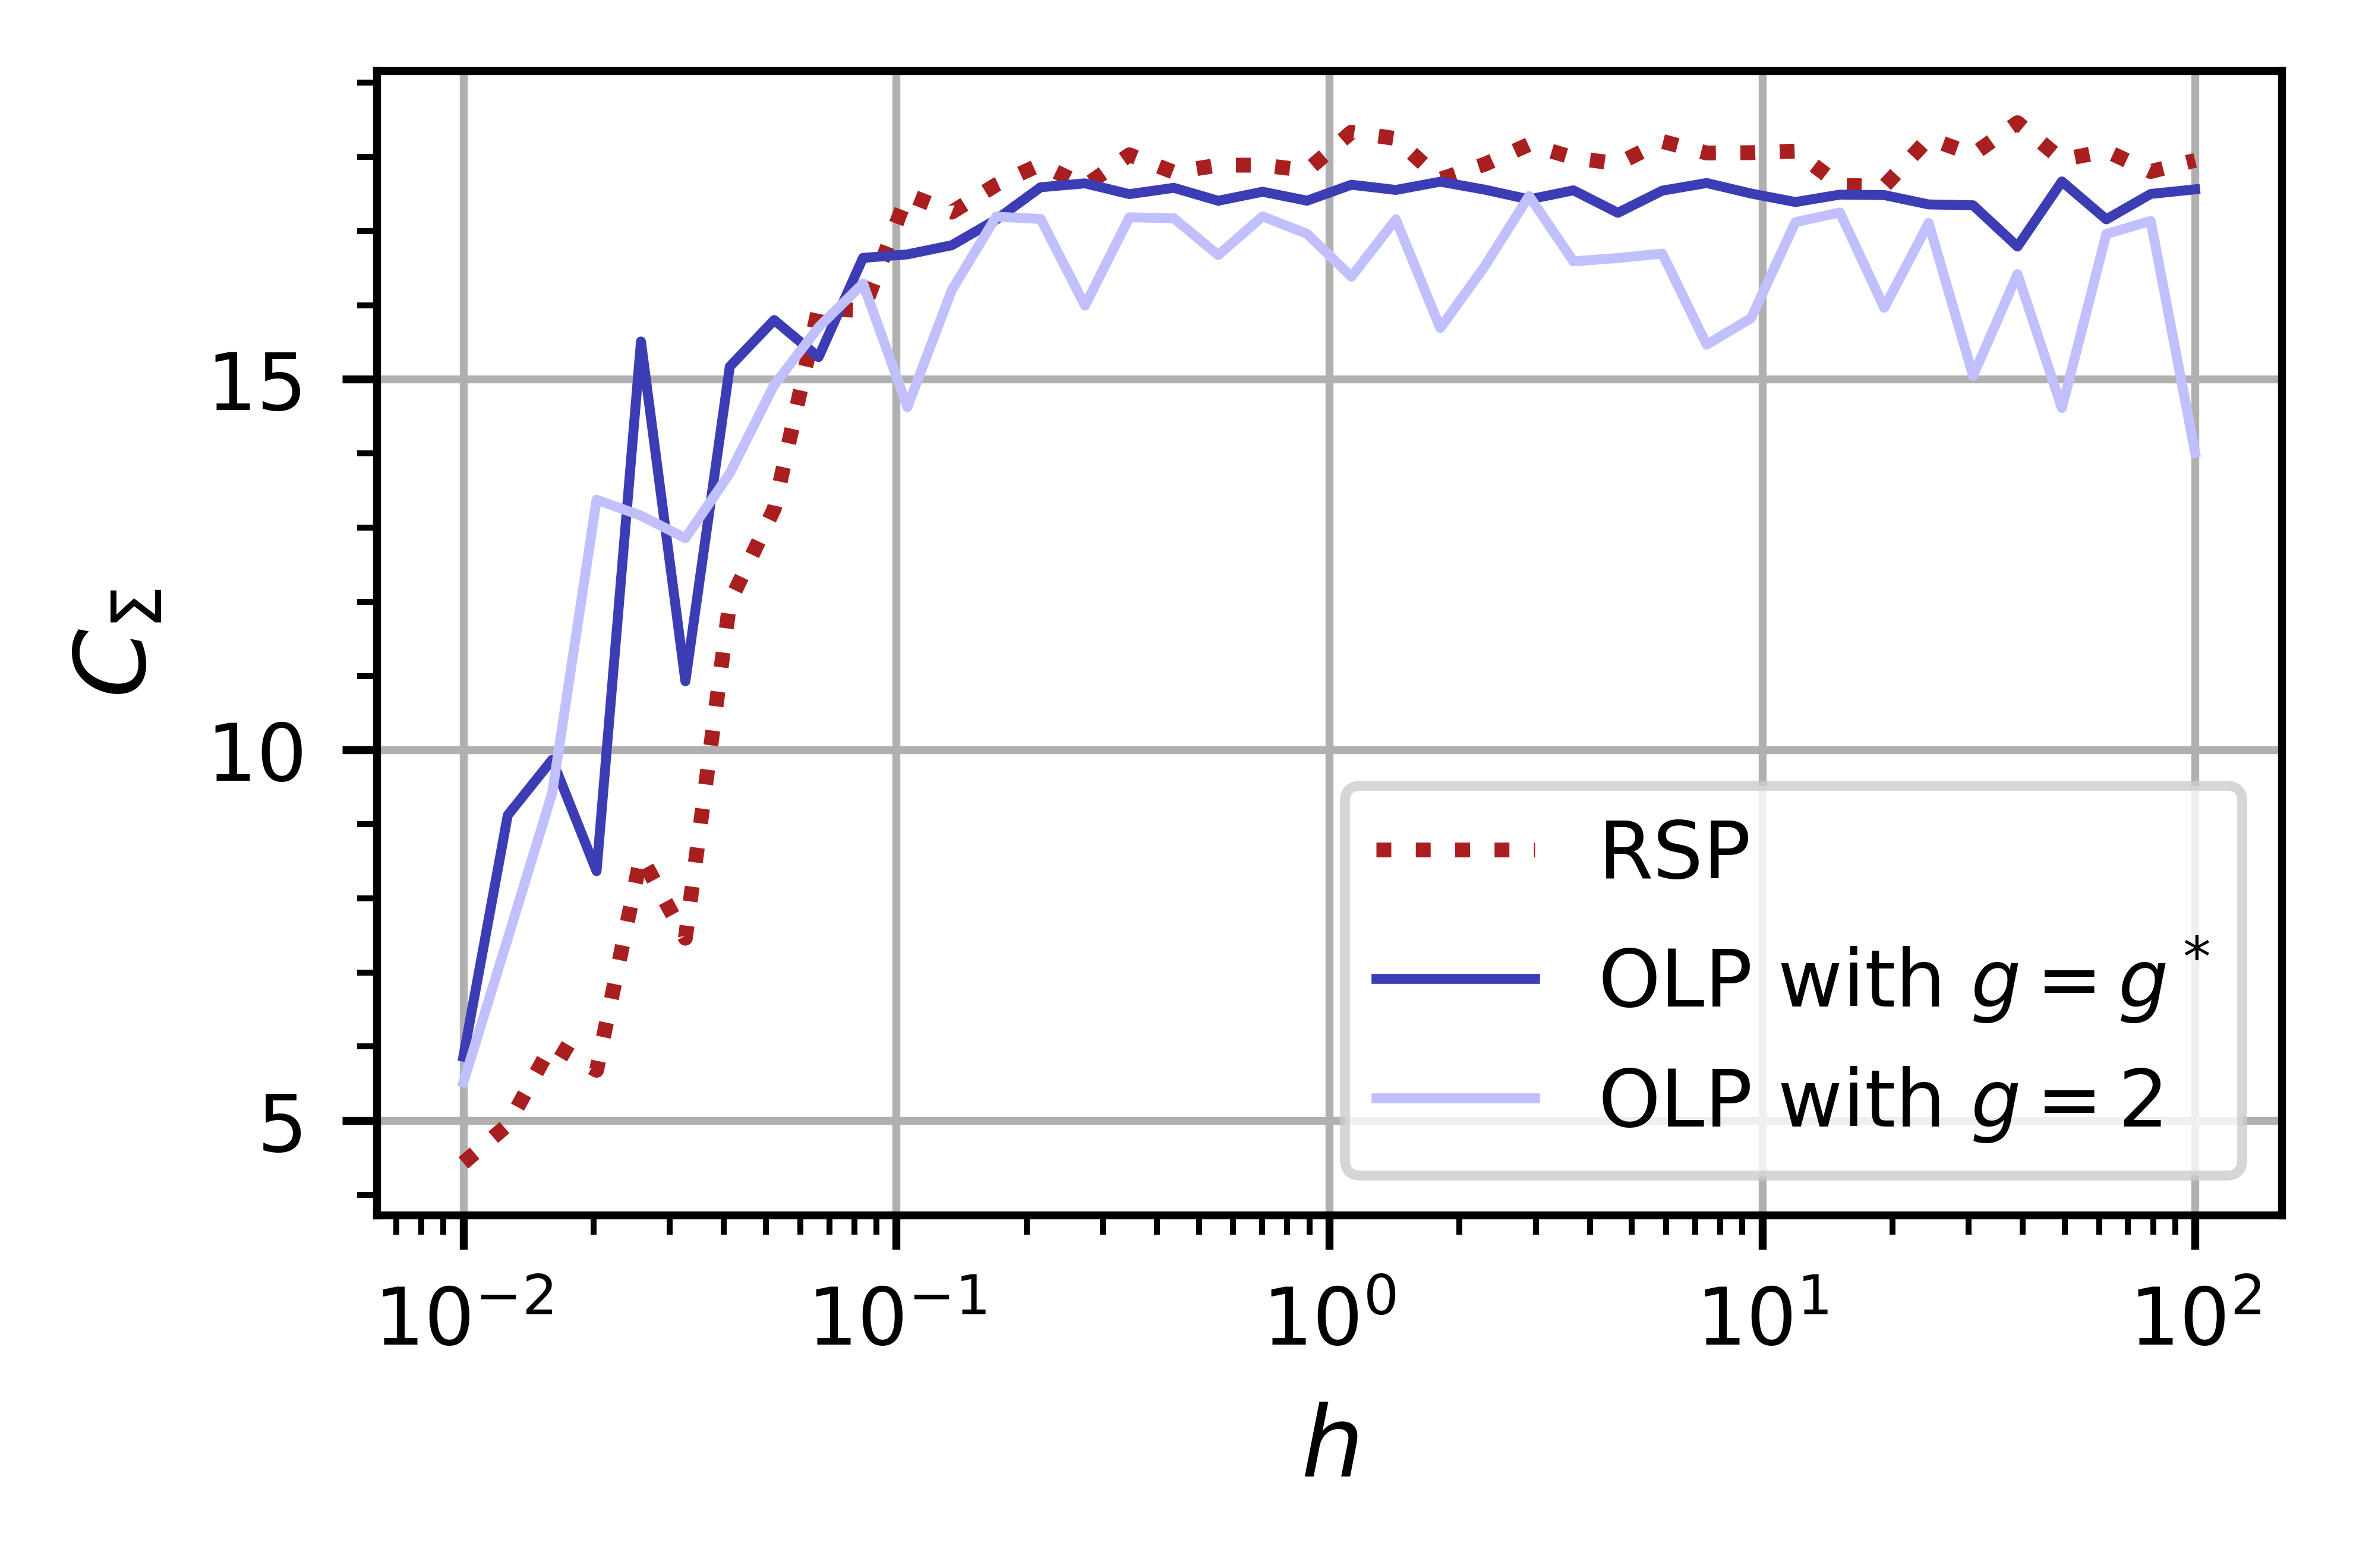

In [124]:
palette = ['#C0C0FE', '#1616FD', '#3C3CB4', '#A91F1F']
# Increase the figure size
plt.figure(figsize=(3.4, 2.3), dpi=1200)

# Plot each line with a distinct style and label
plt.plot(h_vec, sum_capacities_rsp, label='RSP', linestyle=':', marker='x', linewidth=1.5, color = palette[3], markersize=0)
plt.plot(h_vec, sum_capacities_olp_opt, label='OLP with $g=g^*$', linestyle='-', marker='o', linewidth=1, color = palette[2], markersize=0)
plt.plot(h_vec, sum_capacities_olp_nopt, label='OLP with $g=2$', linestyle='-', marker='o', linewidth=1, color = palette[0], markersize=0)
plt.xscale('log')

# Add labels and title with increased font sizes
plt.xlabel('$h$', fontsize=10)
plt.ylabel('$C_{\Sigma}$', fontsize=10)
#plt.title('Sum Capacities at different noise levels', fontsize=12)

plt.minorticks_on()

# Add a legend
plt.grid()
plt.legend(fontsize=8)

# Increase tick label sizes
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

### Capacities vs $\eta$ plot

In [138]:
g_rsp = fig_params['RSP_OPT']['g']
h_rsp = fig_params['RSP_OPT']['h']
g_olp_opt = fig_params['OLP_OPT']['g']
h_olp_opt = fig_params['OLP_OPT']['h']
g_olp_nopt = fig_params['OLP_NOOPT']['g']
h_olp_nopt = fig_params['OLP_NOOPT']['h']

# load data
df_rsp = read_datafile(data_path, 20, g_rsp, h_rsp)
df_olp_opt = read_datafile(data_path, 20, g_olp_opt, h_olp_opt)
df_olp_nopt = read_datafile(data_path, 20, g_olp_nopt, h_olp_nopt)

In [139]:
eta_max = 20
capacities_rsp = []
capacities_olp_opt = []
capacities_olp_nopt = []
for eta in range(1, eta_max+1):
    capacities_rsp.append(compute_capacity(df_rsp, time_series, eta, f_p=True)[1])
    capacities_olp_opt.append(compute_capacity(df_olp_opt, time_series, eta, f_p=True)[1])
    capacities_olp_nopt.append(compute_capacity(df_olp_nopt, time_series, eta, f_p=True)[1])

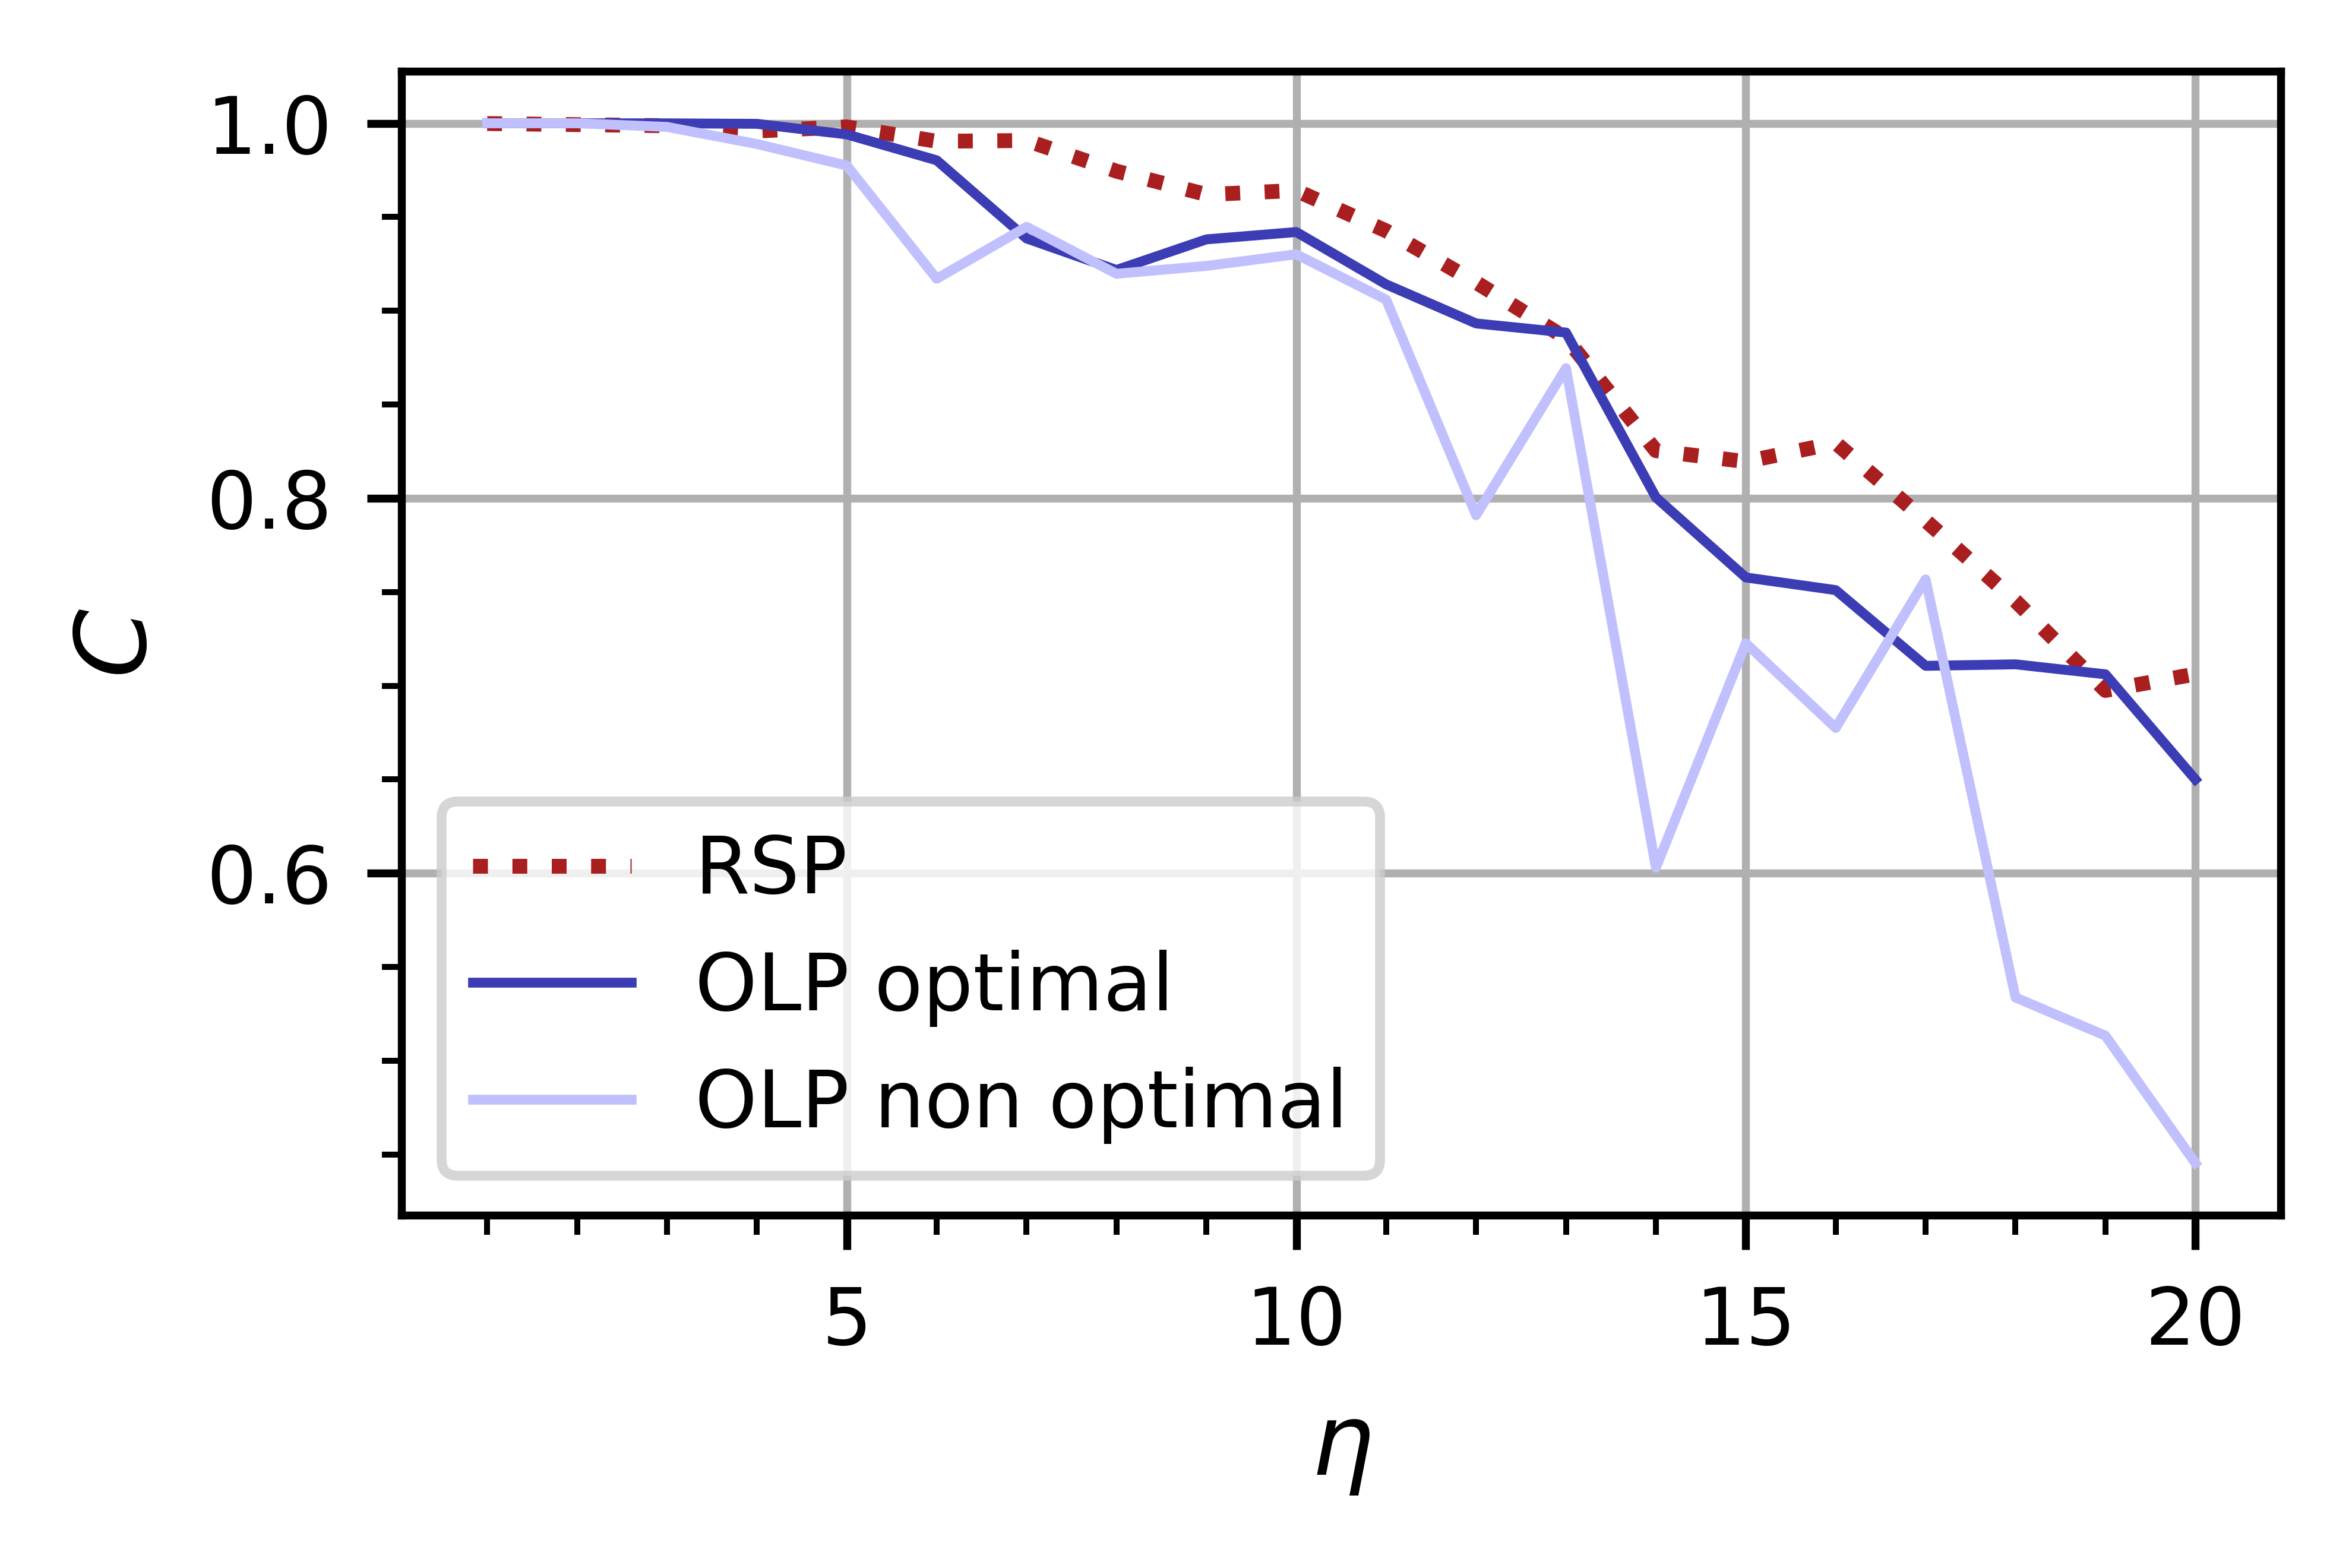

In [143]:
palette = ['#C0C0FE', '#1616FD', '#3C3CB4', '#A91F1F']
# Increase the figure size
plt.figure(figsize=(3.4, 2.3), dpi=1200)
eta_vec = np.arange(1, eta_max+1)

# Plot each line with a distinct style and label
plt.plot(eta_vec, capacities_rsp, label='RSP', linestyle=':', marker='x', linewidth=1.5, color = palette[3], markersize=0)
plt.plot(eta_vec, capacities_olp_opt, label='OLP optimal', linestyle='-', marker='o', linewidth=1, color = palette[2], markersize=0)
plt.plot(eta_vec, capacities_olp_nopt, label='OLP non optimal', linestyle='-', marker='o', linewidth=1, color = palette[0], markersize=0)

# Add labels and title with increased font sizes
plt.xlabel('$\eta$', fontsize=10)
plt.ylabel('$C$', fontsize=10)
#plt.title('Sum Capacities at different noise levels', fontsize=12)

plt.minorticks_on()

# Add a legend
plt.grid()
plt.legend(fontsize=8)

# Increase tick label sizes
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()